In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
!wandb login 2ac160a9e3551521e6d4cb0046c4a2b3b04abe4b

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import math
import time
import wandb
%matplotlib inline

# Utility Functions

- Mean Square
- Sigmoid
- Soft Max
- Cross Entropy
- tanh


In [ ]:
# Constants
SIGMOID = "sigmoid"
MEAN_SQUARE_ERROR = "mse"
SOFT_MAX = "softmax"
RE_LU = "relu"
CROSS_ENTROPY = "cross_entropy"
TAN_H = "tanh"

def sigmoid(z):
    # z = np.clip(z,500,-500)
    return 1.0 / (1 + np.exp(-(z)))


def tanh(z):
    return np.tanh(z)


def sin(z):
    return np.sin(z)


def reLu(z):
    return (z>0)*(z) + ((z<0)*(z)*0.01)
    #return np.maximum(z,0)
    #return np.where(z<0, 0.01*z, z)

def softmax(Z):
    # Z = np.clip(Z,500,-500)
    Z -= np.max(Z)
    # Compute softmax
    exp_Z = np.exp(Z)
    softmax_output = exp_Z / np.sum(exp_Z)
    return softmax_output


def del_sigmoid(z):
    # z = np.clip(z,500,-500)
    return  (1.0 / (1 + np.exp(-(z))))*(1 -  1.0 / (1 + np.exp(-(z))))

def del_tanh(z):
    return 1 - np.tanh(z) ** 2


def del_reLu(z):
    return (z>0)*np.ones(z.shape) + (z<0)*(0.01*np.ones(z.shape) )


activation = {
    SIGMOID :sigmoid,
    SOFT_MAX :softmax,
    RE_LU :reLu,
    TAN_H :tanh,
}
del_activation = {
    SIGMOID : del_sigmoid,
    TAN_H : del_tanh,
    RE_LU : del_reLu,
}

# Question-1


4422102/4422102 [==============================] - 0s 0us/step


AssertionError: 

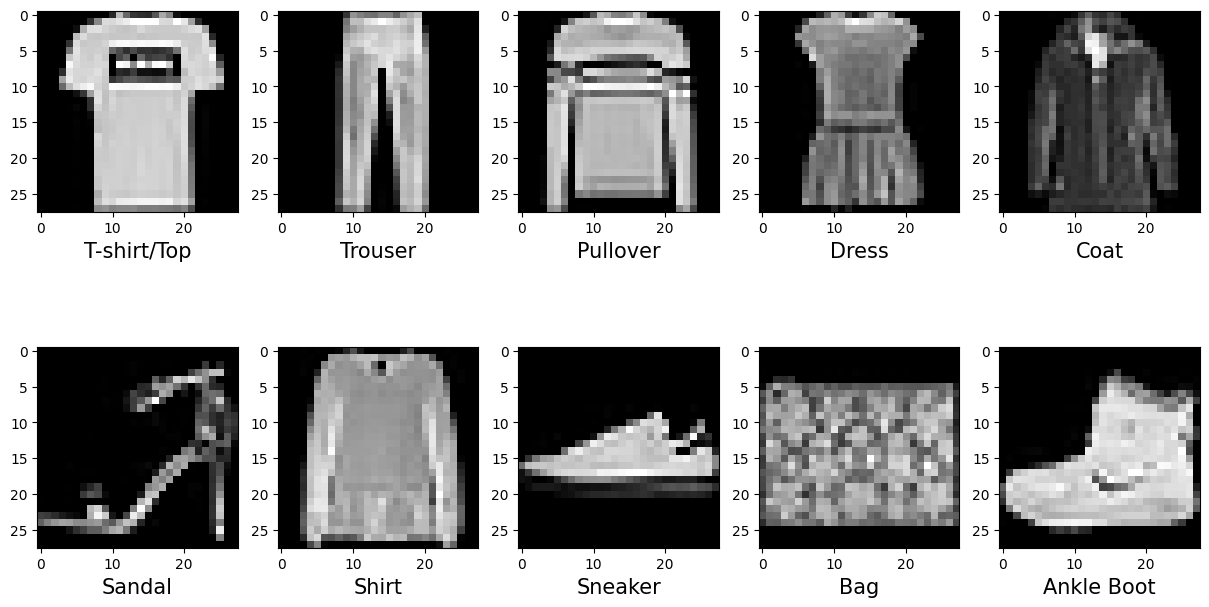

In [ ]:
(X_train,y_train), (X_test,y_test) = fashion_mnist.load_data()
X = X_train
Y = y_train
countHash = dict()
total_items = 0
class_dictionary = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
img_classes_fig = plt.figure("The image classes",figsize=(15, 8))
grid_specification = img_classes_fig.add_gridspec(2, 5)
Image_list = []
Image_class_label = []

for num_class in range(10):
  for j in range(X_train.shape[0]):
    if y_train[j]==num_class and num_class<5:
      globals()["ax" + str(num_class + 1)] = img_classes_fig.add_subplot(grid_specification[0, num_class])
      plt.imshow(X_train[j], cmap="gray",)
      Image_list.append(X_train[j])
      plt.xlabel(class_dictionary[num_class], fontsize=15)
      Image_class_label.append(class_dictionary[num_class])
      break
    elif y_train[j]==num_class and num_class>=5:
      globals()["ax" + str(5 + num_class + 1)] = img_classes_fig.add_subplot(grid_specification[1, num_class-5])
      plt.imshow(X_train[j], cmap="gray")
      Image_list.append(X_train[j])
      plt.xlabel(class_dictionary[num_class], fontsize=15)
      Image_class_label.append(class_dictionary[num_class])
      break

wandb.init(project='dl-assigment-1', entity='cs23m007')
wandb.log({"sample images":[wandb.Image(img,caption = caption) for img,caption in zip(Image_list, Image_class_label)]})

plt.show()

# Question 3


In [ ]:
import time
GRAD_A = "del_a"
GRAD_W = "del_w"
GRAD_H = "del_h"
GRAD_B = "del_b"

def Xavier_initializer(dim):
    '''
    Xavier weight initialization for neural networks.

    Parameters:
    - dim: Tuple (output_dim, input_dim) representing the dimensions of the weight matrix.

    Returns:
    - A numpy array of shape (output_dim, input_dim) with Xavier-initialized values.
    '''
    xavier_stddev = np.sqrt(2 / (dim[1] + dim[0]))
    return np.random.normal(0, xavier_stddev, size=(dim[0], dim[1]))

def random_initializer(dim):
    '''
    Random weight initialization for neural networks.

    Parameters:
    - dim: Tuple (output_dim, input_dim) representing the dimensions of the weight matrix.

    Returns:
    - A numpy array of shape (output_dim, input_dim) with randomly initialized values.
    '''
    return np.random.normal(0, 1, size=(dim[0], dim[1]))

def He_initializer(dim):
    '''
    He weight initialization for neural networks.

    Parameters:
    - dim: Tuple (output_dim, input_dim) representing the dimensions of the weight matrix.

    Returns:
    - A numpy array of shape (output_dim, input_dim) with He-initialized values.
    '''
    He_stddev = np.sqrt(2 / (dim[1]))
    return np.random.normal(0, 1, size=(dim[0], dim[1])) * He_stddev


def meanSquaredErrorLoss(Y_true, Y_pred):
    '''
    Calculates the Mean Squared Error (MSE) loss between true and predicted values.

    Arguments:
    - Y_true (numpy.ndarray): True output labels.
    - Y_pred (numpy.ndarray): Predicted output labels.

    Returns:
    - float: Mean Squared Error loss.
    '''
    return np.mean((Y_true - Y_pred) * (Y_true - Y_pred))

def crossEntropyLoss( Y_true, Y_pred):
    '''
    Calculates the Cross-Entropy loss between true and predicted probability distributions.

    Arguments:
    - Y_true (numpy.ndarray): True output labels in one-hot encoded form.
    - Y_pred (numpy.ndarray): Predicted probability distributions.

    Returns:
    - float: Cross-Entropy loss.
    '''
    # CE = [-Y_true[i] * np.log(Y_pred[i]) for i in range(len(Y_pred))]
    # crossEntropy = np.mean(CE)
    # return crossEntropy
    eps = 1e-15
    Y_pred = np.clip(Y_pred,eps,1.0-eps)
    loss = -np.sum(Y_true*np.log(Y_pred),axis=1)
    loss = np.mean(loss)
    return loss
# helper functions
def oneHotEncode(num_classes, Y_train_raw):
    '''
    Performs one-hot encoding on the provided labels.

    Parameters:
    - Y_train_raw (numpy.ndarray): Raw output labels.

    Returns:
    - Ydata (numpy.ndarray): One-hot encoded representation of the labels.
    '''
    res = np.zeros((num_classes, Y_train_raw.shape[0]))
    i = 0
    while(i<Y_train_raw.shape[0]):
        res[int(Y_train_raw[i])][i] = 1.0
        i+=1
    return res

def printAccuracy(epoch,trainingloss,trainingaccuracy,validationaccuracy,elapsed,alpha):
    print("Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f, Learning Rate: %.3e"% (epoch,trainingloss,trainingaccuracy,validationaccuracy,elapsed,alpha,))


def accuracy(Y_true, Y_pred, data_size):
    '''
    Calculates the accuracy of the model's predictions.

    Arguments:
    - Y_true (numpy.ndarray): True output labels in one-hot encoded form.
    - Y_pred (numpy.ndarray): Predicted output labels in one-hot encoded form.
    - data_size (int): Number of samples in the dataset.

    Returns:
    - float: Accuracy of the model.
    - list: True labels.
    - list: Predicted labels.
    '''
    Y_true_vals, Y_pred_vals = [], []
    correct_vals = 0
    i = 0
    while i<data_size:
        Y_true_val = np.argmax(Y_true[:, i])
        Y_true_vals.append(Y_true_val)

        Y_pred_val = np.argmax(Y_pred[:, i])
        Y_pred_vals.append(Y_pred_val)
        if Y_true_vals[i] == Y_pred_vals[i]:
            correct_vals += 1
        i+=1
    acc = correct_vals / data_size
    return acc, Y_true_vals, Y_pred_vals


class FeedForwardNeuralNetwork:
    '''
    Neural network model for feedforward architecture.

    Attributes:
    - hidden_layers (List[int]): List representing the number of neurons in each hidden layer.
    - output_layer_neuron (int): Number of neurons in the output layer.
    - X_train_raw (numpy.ndarray): Raw training input data.
    - Y_train_raw (numpy.ndarray): Raw training output labels.
    - N_train (int): Number of training samples.
    - X_val_raw (numpy.ndarray): Raw validation input data.
    - Y_val_raw (numpy.ndarray): Raw validation output labels.
    - N_val (int): Number of validation samples.
    - X_test_raw (numpy.ndarray): Raw test input data.
    - Y_test_raw (numpy.ndarray): Raw test output labels.
    - N_test (int): Number of test samples.
    - batch_size (int): Size of the mini-batch used during training.
    - weight_decay (float): Weight decay regularization parameter.
    - learning_rate (float): Learning rate for optimization.
    - epochs (int): Number of training epochs.
    - activation_fun (str): Activation function used in hidden layers.
    - initializer (str): Weight initialization method - "RANDOM" (default), "XAVIER", or "HE".
    - optimizer (str): Optimization algorithm - "SGD" (default), "MBGD", "NAGD", "RMS", "ADAM", or "NADAM".
    - loss_function (str): Loss function used for training - "CROSS_ENTROPY" (default) or "MSE".

    Methods:
    - __init__: Initializes the neural network with the provided parameters and initializes weights and biases.
    - initializeNeuralNet: Helper function to initialize weights and biases for the neural network layers.

    Note:
    - The network architecture is defined by the combination of hidden_layers and output_layer_neuron.
    - The input data is expected to be flattened, with dimensions (num_features, num_samples).
    - Raw input data is normalized to the range [0, 1].
    - The activation function and its derivative are specified based on the chosen activation_fun.
    - The initializer for weights is selected from "RANDOM" (default), "XAVIER", or "HE".
    - The optimization algorithm can be chosen from "SGD" (default), "MBGD", "NAGD", "RMS", "ADAM", or "NADAM".
    - The loss function for training is chosen from "CROSS_ENTROPY" (default) or "MSE".
    '''
    def __init__(
        self,
        num_hidden_layers,
        num_hidden_neurons,
        X_train_raw,
        Y_train_raw,
        N_train,
        X_val_raw,
        Y_val_raw,
        N_val,
        X_test_raw,
        Y_test_raw,
        N_test,
        optimizer,
        batch_size,
        weight_decay,
        learning_rate,
        max_epochs,
        activation,
        initializer,
        loss

    ):


        self.num_classes = np.max(Y_train_raw) + 1  # NUM_CLASSES

        self.num_hidden_layers = num_hidden_layers
        self.num_hidden_neurons = num_hidden_neurons
        self.output_layer_size = self.num_classes
        self.img_height = X_train_raw.shape[1]
        self.img_width = X_train_raw.shape[2]
        self.img_flattened_size = self.img_height * self.img_width

        # self.network = layers
        self.network = (
            [self.img_flattened_size]
            + num_hidden_layers * [num_hidden_neurons]
            + [self.output_layer_size]
        )

        self.N_train = N_train
        self.N_val = N_val
        self.N_test = N_test



        self.X_train = np.transpose(
            X_train_raw.reshape(
                X_train_raw.shape[0], X_train_raw.shape[1] * X_train_raw.shape[2]
            )
        )
        self.X_test = np.transpose(
            X_test_raw.reshape(
                X_test_raw.shape[0], X_test_raw.shape[1] * X_test_raw.shape[2]
            )
        )
        self.X_val = np.transpose(
            X_val_raw.reshape(
                X_val_raw.shape[0], X_val_raw.shape[1] * X_val_raw.shape[2]
            )
        )


        self.X_train = self.X_train / 255
        self.X_test = self.X_test / 255
        self.X_val = self.X_val / 255

        self.Y_train = oneHotEncode(self.num_classes,Y_train_raw)
        self.Y_val = oneHotEncode(self.num_classes,Y_val_raw)
        self.Y_test = oneHotEncode(self.num_classes,Y_test_raw)


        self.Activations_dict = {"SIGMOID": sigmoid, "TANH": tanh, "RELU": reLu}
        self.DerActivation_dict = {
            "SIGMOID": del_sigmoid,
            "TANH": del_tanh,
            "RELU": del_reLu,
        }

        self.Initializer_dict = {
            "XAVIER": Xavier_initializer,
            "RANDOM": random_initializer,
            "HE": He_initializer
        }

        self.Optimizer_dict = {
            "SGD": self.sgdMiniBatch,
            "MGD": self.mgd,
            "NAG": self.nag,
            "RMSPROP": self.rmsProp,
            "ADAM": self.adam,
            "NADAM": self.nadam,
        }

        self.activation = self.Activations_dict[activation]
        self.der_activation = self.DerActivation_dict[activation]
        self.optimizer = self.Optimizer_dict[optimizer]
        self.initializer = self.Initializer_dict[initializer]
        self.loss_function = loss
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.alpha = learning_rate

        self.weights, self.biases = self.initializeNeuralNet(self.network)

    def L2RegularisationLoss(self, weight_decay):
        '''
        Calculates the L2 regularization loss for the neural network weights.

        Arguments:
        - weight_decay (float): Regularization parameter.

        Returns:
        - float: L2 regularization loss.
        '''
        ALPHA = weight_decay
        return ALPHA * np.sum(
            [
                np.linalg.norm(self.weights[str(i + 1)]) ** 2
                for i in range(len(self.weights))
            ]
        )

    def predict(self,X,length_dataset):
        '''
        Generates predictions for a given input dataset.

        Arguments:
        - X (numpy.ndarray): Input dataset.
        - length_dataset (int): Number of samples in the dataset.

        Returns:
        - numpy.ndarray: Predicted output matrix.
        '''
        Y_pred = []
        i = 0
        while i < length_dataset:
            Y, H, A = self.forwardPropagate(
                X[:, i].reshape(self.img_flattened_size, 1),
                self.weights,
                self.biases,
            )
            Y_prime = Y.reshape(self.num_classes,)
            Y_pred.append(Y_prime)
            i+=1
        return np.array(Y_pred).transpose()

    def initializeNeuralNet(self, layers):
        '''
        Initializes weights and biases for the neural network layers.

        Parameters:
        - layers (List[int]): List representing the number of neurons in each layer.

        Returns:
        - weights (dict): Dictionary containing weight matrices for each layer.
        - biases (dict): Dictionary containing bias vectors for each layer.
        '''
        weights,biases = dict(),dict()
        l = 0
        while(l< len(layers) - 1):
            dummy_w = self.initializer(dim=[layers[l + 1], layers[l]])
            dummy_b = np.zeros((layers[l + 1], 1))
            key = str(l + 1)
            weights[key],biases[key] = dummy_w,dummy_b
            l+=1
        return weights, biases


    def forwardPropagate(self, X_train_batch, weights, biases):
        '''
        Performs forward propagation to calculate the output of the neural network.

        Arguments:
        - X_train_batch (numpy.ndarray): Input matrix for a batch of training data.
        - weights (dict): Dictionary containing weight matrices for each layer.
        - biases (dict): Dictionary containing bias vectors for each layer.

        Returns:
        - Y_cap (numpy.ndarray): Predicted output matrix for the given input batch.
        - H (dict): Dictionary containing activation values for each layer during forward propagation.
        - A (dict): Dictionary containing preactivation values for each layer during forward propagation.
        '''
        # Number of layers = length of weight matrix + 1
        num_layers = len(weights) + 1
        # A - Preactivations
        # H - Activations
        X = X_train_batch
        H,A = {},{}
        H["0"],A["0"] = X, X

        W = weights[str(1)]
        b = biases[str(1)]
        A[str(1)] = np.add(np.matmul(W, X), b)
        H[str(1)] = self.activation(A[str(1)])
        l = 1
        while l < num_layers - 2:
            key = str(l + 1)
            prev_layer_key = str(l)
            W,b = weights[key],biases[key]
            A[key] = np.add(np.matmul(W, H[prev_layer_key]), b)
            H[key] = self.activation(A[str(l + 1)])
            l+=1

        # Here the last layer is not activated as it is a regression problem
        last_layer_key = str(num_layers - 1)
        W,b = weights[last_layer_key],biases[last_layer_key]
        A[last_layer_key] = np.add(np.matmul(W, H[str(num_layers - 2)]), b)
        # Y = softmax(A[-1])
        Y_cap = softmax(A[last_layer_key])
        H[last_layer_key] = Y_cap
        return Y_cap, H, A

    def backPropagate(
        self, Y, H, A, Y_train_batch, weight_decay=0
    ):
        '''
        Backpropagate through the neural network to compute gradients with respect to weights and biases.

        Parameters:
        - y_cap: The predicted output of the neural network.
        - H: Dictionary containing hidden layer outputs.
        - A: Dictionary containing pre-activation values for each layer.
        - y_true: The true output labels.
        - weight_decay: Regularization parameter to control overfitting (default is 0).

        Returns:
        - del_w: List of weight gradients for each layer.
        - del_b: List of bias gradients for each layer.
        '''

        ALPHA = weight_decay
        gradients_weights = []
        gradients_biases = []
        num_layers = len(self.network)

        # Gradient with respect to the output layer is absolutely fine.
        if self.loss_function == "CROSS":
            globals()["grad_a" + str(num_layers - 1)] = -(Y_train_batch - Y)
        elif self.loss_function == "MSE":
            globals()["grad_a" + str(num_layers - 1)] = np.multiply(
                2 * (Y - Y_train_batch), np.multiply(Y, (1 - Y))
            )

        for l in range(num_layers - 2, -1, -1):

            if ALPHA != 0:
                globals()["grad_W" + str(l + 1)] = (
                    np.outer(globals()["grad_a" + str(l + 1)], H[str(l)])
                    + ALPHA * self.weights[str(l + 1)]
                )
            elif ALPHA == 0:
                globals()["grad_W" + str(l + 1)] = np.outer(
                    globals()["grad_a" + str(l + 1)], H[str(l)]
                )
            globals()["grad_b" + str(l + 1)] = globals()["grad_a" + str(l + 1)]
            gradients_weights.append(globals()["grad_W" + str(l + 1)])
            gradients_biases.append(globals()["grad_b" + str(l + 1)])
            if l != 0:
                globals()["grad_h" + str(l)] = np.matmul(
                    self.weights[str(l + 1)].transpose(),
                    globals()["grad_a" + str(l + 1)],
                )
                globals()["grad_a" + str(l)] = np.multiply(
                    globals()["grad_h" + str(l)], self.der_activation(A[str(l)])
                )
            elif l == 0:

                globals()["grad_h" + str(l)] = np.matmul(
                    self.weights[str(l + 1)].transpose(),
                    globals()["grad_a" + str(l + 1)],
                )
                globals()["grad_a" + str(l)] = np.multiply(
                    globals()["grad_h" + str(l)], (A[str(l)])
                )
        return gradients_weights, gradients_biases

    #Optimisers defined here onwards
    def sgd(self, epochs, length_dataset, learning_rate, weight_decay=0):
        '''
        Implement Stochastic Gradient Descent (SGD) optimization for training the neural network.

        Parameters:
        - epochs: Number of training epochs.
        - length_dataset: Number of samples in the training dataset.
        - learning_rate: Learning rate for the optimization.
        - weight_decay: Regularization parameter to control overfitting (default is 0).

        Returns:
        - trainingloss: List of training losses per epoch.
        - trainingaccuracy: List of training accuracies per epoch.
        - validationaccuracy: List of validation accuracies per epoch.
        - Y_pred: Predicted outputs after training.
        '''
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []
        network_size = len(self.network)

        # Extract a subset of the training dataset
        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]
        epoch = 0

        while epoch < epochs:
            start_time = time.time()

            # Reshape input and target arrays
            X_train, Y_train = X_train.reshape(
                self.img_flattened_size, length_dataset
            ), Y_train.reshape(self.num_classes, length_dataset)

            LOSS = []
            del_w = [np.zeros((self.network[l + 1], self.network[l])) for l in range(0, len(self.network) - 1)]
            del_b = [np.zeros((self.network[l + 1], 1)) for l in range(0, len(self.network) - 1)]

            i = 0

            # Iterate through the dataset
            while i < length_dataset:
                Y_cap, H, A = self.forwardPropagate(
                    X_train[:, i].reshape(self.img_flattened_size, 1), self.weights, self.biases
                )
                grad_weights, grad_biases = self.backPropagate(
                    Y_cap, H, A, Y_train[:, i].reshape(self.num_classes, 1)
                )

                del_w = [grad_weights[network_size - 2 - i] for i in range(network_size - 1)]
                del_b = [grad_biases[network_size - 2 - i] for i in range(network_size - 1)]

                l2Loss = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(self.Y_train[:, i].reshape(self.num_classes, 1), Y_cap) + l2Loss)
                else:
                    LOSS.append(crossEntropyLoss(self.Y_train[:, i].reshape(self.num_classes, 1), Y_cap) + l2Loss)

                # Update weights and biases
                for j in range(len(self.weights)):
                    self.weights[str(j + 1)] = self.weights[str(j + 1)] - learning_rate * del_w[j]

                for j in range(len(self.biases)):
                    self.biases[str(j + 1)] = self.biases[str(j + 1)] - learning_rate * del_b[j]

                i += 1

            elapsed = time.time() - start_time

            # Compute training and validation accuracies, and append to lists
            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch += 1

        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred




    def sgdMiniBatch(self, epochs,length_dataset, batch_size, learning_rate, weight_decay = 0):
        '''
        Train the neural network using Stochastic Gradient Descent (SGD) with Mini-Batch updates.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''
        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]

        trainingloss = []
        trainingaccuracy, validationaccuracy = [], []

        num_points_seen = 0

        num_layers = len(self.network)
        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)

            LOSS = []
            #Y_pred = []
            deltaw,deltab = [],[]
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))

            i = 0
            while i < length_dataset:
                Y,H,A = self.forwardPropagate(X_train[:,i].reshape(self.img_flattened_size,1), self.weights, self.biases)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for j in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - j] + deltaw[j])

                for j in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - j] + deltab[j])
                deltaw,deltab = tempDeltaw,tempDeltab
                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )
                num_points_seen +=1

                if int(num_points_seen) % batch_size == 0:


                    self.weights = {str(i+1):(self.weights[str(i+1)] - learning_rate*deltaw[i]/batch_size) for i in range(len(self.weights))}
                    self.biases = {str(i+1):(self.biases[str(i+1)] - learning_rate*deltab[i]) for i in range(len(self.biases))}

                    #resetting gradient updates
                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))
                i+=1
            elapsed = time.time() - start_time

            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1


        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred

    def mgd(self, epochs,length_dataset, batch_size, learning_rate, weight_decay = 0):
        '''
        Train the neural network using the Mini-Batch Gradient Descent (MGD) optimization algorithm with momentum.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''

        GAMMA = 0.9

        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]


        trainingloss = []
        trainingaccuracy, validationaccuracy = [], []

        num_layers = len(self.network)

        prev_v_w,prev_v_b = [],[]
        for l in range(0, len(self.network)-1):
            prev_v_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            prev_v_b.append(np.zeros((self.network[l+1], 1)))

        num_points_seen = 0
        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)

            LOSS = []

            deltaw = []
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))

            deltab = []
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))

            for i in range(length_dataset):
                Y,H,A = self.forwardPropagate(self.X_train[:,i].reshape(self.img_flattened_size,1), self.weights, self.biases)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,self.Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for j in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - j] + deltaw[j])

                for j in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - j] + deltab[j])
                deltaw,deltab = tempDeltaw,tempDeltab

                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )
                num_points_seen +=1

                if int(num_points_seen) % batch_size == 0:

                    v_w = [GAMMA*prev_v_w[i] + learning_rate*deltaw[i]/batch_size for i in range(num_layers - 1)]
                    v_b = [GAMMA*prev_v_b[i] + learning_rate*deltab[i]/batch_size for i in range(num_layers - 1)]
                    tempWeights = {}
                    tempBiases = {}
                    for l in range(len(self.weights)):
                        tempWeights[str(l+1)] = self.weights[str(l+1)] - v_w[l]
                    self.weights = tempWeights

                    for l in range(len(self.biases)):
                        tempBiases[str(l+1)] = self.biases[str(l+1)] - v_b[l]
                    self.biases = tempBiases

                    prev_v_w = v_w
                    prev_v_b = v_b

                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))

            elapsed = time.time() - start_time
            #Y_pred = np.array(Y_pred).transpose()
            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1

        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred



    def nag(self,epochs,length_dataset, batch_size,learning_rate, weight_decay = 0):
        '''
        Train the neural network using the Nesterov Accelerated Gradient (NAG) optimization algorithm.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''
        GAMMA = 0.9

        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]


        trainingloss = []
        trainingaccuracy, validationaccuracy = [], []

        num_layers = len(self.network)

        prev_v_w,prev_v_b = [],[]
        for l in range(0, len(self.network)-1):
            prev_v_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            prev_v_b.append(np.zeros((self.network[l+1], 1)))

        num_points_seen = 0
        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)

            LOSS = []
            #Y_pred = []

            deltaw = []
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))

            deltab = []
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))

            v_w = [GAMMA*prev_v_w[l] for l in range(0, len(self.network)-1)]
            v_b = [GAMMA*prev_v_b[l] for l in range(0, len(self.network)-1)]
            i = 0
            while i < length_dataset:
                winter = dict()
                for l in range(0, len(self.network)-1):
                    winter[str(l+1)] = self.weights[str(l+1)] - v_w[l]

                binter = dict()
                for l in range(0, len(self.network)-1):
                    binter[str(l+1)] = self.biases[str(l+1)] - v_b[l]

                Y,H,A = self.forwardPropagate(self.X_train[:,i].reshape(self.img_flattened_size,1), winter, binter)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,self.Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for l in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - l] + deltaw[l])

                for l in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - l] + deltab[l])
                deltaw,deltab = tempDeltaw,tempDeltab

                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )

                num_points_seen +=1

                if int(num_points_seen) % batch_size == 0:

                    v_w = [GAMMA*prev_v_w[i] + learning_rate*deltaw[i]/batch_size for i in range(num_layers - 1)]
                    v_b = [GAMMA*prev_v_b[i] + learning_rate*deltab[i]/batch_size for i in range(num_layers - 1)]

                    tempW = dict()
                    for l in range(len(self.weights)):
                        tempW[str(l+1)] = self.weights[str(l+1)] - v_w[l]

                    tempB = dict()
                    for l in range(len(self.biases)):
                        tempB[str(l+1)] = self.biases[str(l+1)] - v_b[l]

                    self.weights,self.biases = tempW,tempB
                    prev_v_w, prev_v_b = v_w, v_b

                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))

                i+=1


            elapsed = time.time() - start_time
            #Y_pred = np.array(Y_pred).transpose()
            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1
        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred


    def rmsProp(self, epochs,length_dataset, batch_size, learning_rate, weight_decay = 0):
        '''
        Train the neural network using the RMSProp optimization algorithm.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''

        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]


        trainingloss = []
        trainingloss = []
        trainingaccuracy, validationaccuracy = [], []

        num_layers = len(self.network)
        EPS, BETA = 1e-8, 0.9

        v_w,v_b = [],[]
        for l in range(0, len(self.network)-1):
            v_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            v_b.append(np.zeros((self.network[l+1], 1)))

        num_points_seen = 0
        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)


            LOSS = []
            #Y_pred = []

            deltaw = []
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))

            deltab = []
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))
            i = 0
            while i < length_dataset:

                Y,H,A = self.forwardPropagate(self.X_train[:,i].reshape(self.img_flattened_size,1), self.weights, self.biases)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,self.Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for j in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - j] + deltaw[j])

                for j in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - j] + deltab[j])
                deltaw,deltab = tempDeltaw,tempDeltab

                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )

                num_points_seen +=1

                if int(num_points_seen) % batch_size == 0:

                    v_w = [BETA*v_w[i] + (1-BETA)*(deltaw[i])**2 for i in range(num_layers - 1)]
                    v_b = [BETA*v_b[i] + (1-BETA)*(deltab[i])**2 for i in range(num_layers - 1)]

                    tempW = dict()
                    for l in range(len(self.weights)):
                        tempW[str(l+1)] = self.weights[str(l+1)] - deltaw[l]*(learning_rate/np.sqrt(v_w[l]+EPS))

                    tempB = dict()
                    for l in range(len(self.biases)):
                        tempB[str(l+1)] = self.biases[str(l+1)] - deltab[l]*(learning_rate/np.sqrt(v_b[l]+EPS))


                    self.weights,self.biases = tempW,tempB

                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))
                i+=1

            elapsed = time.time() - start_time
            #Y_pred = np.array(Y_pred).transpose()
            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1

        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred

    def adam(self, epochs,length_dataset, batch_size, learning_rate, weight_decay = 0):
        '''
        Train the neural network using the Adam optimization algorithm.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''
        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]

        trainingloss = []
        trainingaccuracy, validationaccuracy = [], []
        num_layers = len(self.network)
        EPS, BETA1, BETA2 = 1e-8, 0.9, 0.99


        m_w,m_b = [],[]
        for l in range(0, len(self.network)-1):
            m_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            m_b.append(np.zeros((self.network[l+1], 1)))

        v_w,v_b = [],[]
        for l in range(0, len(self.network)-1):
            v_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            v_b.append(np.zeros((self.network[l+1], 1)))

        m_w_hat,m_b_hat = [],[]
        for l in range(0, len(self.network)-1):
            m_w_hat.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            m_b_hat.append(np.zeros((self.network[l+1], 1)))

        v_w_hat,v_b_hat = [],[]
        for l in range(0, len(self.network)-1):
            v_w_hat.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            v_b_hat.append(np.zeros((self.network[l+1], 1)))

        num_points_seen = 0
        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)


            LOSS = []
            #Y_pred = []

            deltaw = []
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))

            deltab = []
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))
            i = 0
            while i < length_dataset:
                Y,H,A = self.forwardPropagate(self.X_train[:,i].reshape(self.img_flattened_size,1), self.weights, self.biases)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,self.Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for j in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - j] + deltaw[j])

                for j in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - j] + deltab[j])
                deltaw,deltab = tempDeltaw,tempDeltab

                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )

                num_points_seen += 1
                ctr = 0
                if int(num_points_seen) % batch_size == 0:
                    ctr += 1

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(BETA1*m_w[l] + (1-BETA1)*deltaw[l])
                    for l in range(0, len(self.network)-1):
                        tempB.append(BETA1*m_b[l] + (1-BETA1)*deltab[l])
                    m_w,m_b = tempW,tempB

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(BETA2*v_w[l] + (1-BETA2)*(deltaw[l])**2)
                    for l in range(0, len(self.network)-1):
                        tempB.append(BETA2*v_b[l] + (1-BETA2)*(deltab[l])**2)
                    v_w,v_b = tempW,tempB

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(m_w[l]/(1-BETA1**(epoch+1)))
                    for l in range(0, len(self.network)-1):
                        tempB.append(m_b[l]/(1-BETA1**(epoch+1)))
                    m_w_hat,m_b_hat = tempW,tempB


                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(v_w[l]/(1-BETA2**(epoch+1)))
                    for l in range(0, len(self.network)-1):
                        tempB.append(v_b[l]/(1-BETA2**(epoch+1)))
                    v_w_hat,v_b_hat = tempW,tempB

                    tempW = dict()
                    for l in range(len(self.weights)):
                        tempW[str(l+1)] = self.weights[str(l+1)] - (learning_rate/np.sqrt(v_w[l]+EPS))*m_w_hat[l]
                    tempB = dict()
                    for l in range(len(self.biases)):
                        tempB[str(l+1)] = self.biases[str(l+1)] - (learning_rate/np.sqrt(v_b[l]+EPS))*m_b_hat[l]
                    self.weights,self.biases = tempW,tempB
                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))
                i+=1

            elapsed = time.time() - start_time
            #Y_pred = np.array(Y_pred).transpose()
            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1

        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred


    def nadam(self, epochs,length_dataset, batch_size, learning_rate, weight_decay = 0):
        '''
        Train the neural network using the Nadam optimization algorithm.

        Parameters:
        - epochs (int): Number of training epochs.
        - length_dataset (int): Number of samples in the training dataset.
        - batch_size (int): Size of each mini-batch during training.
        - learning_rate (float): The learning rate for updating weights and biases.
        - weight_decay (float, optional): L2 regularization term to control overfitting (default is 0).

        Returns:
        - trainingloss (list): List of training losses for each epoch.
        - trainingaccuracy (list): List of training accuracies for each epoch.
        - validationaccuracy (list): List of validation accuracies for each epoch.
        - Y_pred (numpy array): Predicted labels for the validation set after training.

        '''
        X_train = self.X_train[:, :length_dataset]
        Y_train = self.Y_train[:, :length_dataset]


        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []
        num_layers = len(self.network)

        GAMMA, EPS, BETA1, BETA2 = 0.9, 1e-8, 0.9, 0.99

        m_w,m_b = [],[]
        for l in range(0, len(self.network)-1):
            m_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            m_b.append(np.zeros((self.network[l+1], 1)))

        v_w,v_b = [],[]
        for l in range(0, len(self.network)-1):
            v_w.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            v_b.append(np.zeros((self.network[l+1], 1)))

        m_w_hat,m_b_hat = [],[]
        for l in range(0, len(self.network)-1):
            m_w_hat.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            m_b_hat.append(np.zeros((self.network[l+1], 1)))

        v_w_hat,v_b_hat = [],[]
        for l in range(0, len(self.network)-1):
            v_w_hat.append(np.zeros((self.network[l+1], self.network[l])))
        for l in range(0, len(self.network)-1):
            v_b_hat.append(np.zeros((self.network[l+1], 1)))

        num_points_seen = 0

        epoch = 0
        while epoch < epochs:
            start_time = time.time()
            idx = np.random.shuffle(np.arange(length_dataset))
            X_train = X_train[:, idx].reshape(self.img_flattened_size, length_dataset)
            Y_train = Y_train[:, idx].reshape(self.num_classes, length_dataset)

            LOSS = []
            #Y_pred = []
            deltaw = []
            for l in range(0, len(self.network)-1):
                deltaw.append(np.zeros((self.network[l+1], self.network[l])))

            deltab = []
            for l in range(0, len(self.network)-1):
                deltab.append(np.zeros((self.network[l+1], 1)))
            i = 0
            while i < length_dataset:

                Y,H,A = self.forwardPropagate(self.X_train[:,i].reshape(self.img_flattened_size,1), self.weights, self.biases)
                grad_weights, grad_biases = self.backPropagate(Y,H,A,self.Y_train[:,i].reshape(self.num_classes,1))

                tempDeltaw,tempDeltab = [],[]
                for j in range(num_layers - 1):
                    tempDeltaw.append(grad_weights[num_layers-2 - j] + deltaw[j])

                for j in range(num_layers - 1):
                    tempDeltab.append(grad_biases[num_layers-2 - j] + deltab[j])
                deltaw,deltab = tempDeltaw,tempDeltab


                l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
                if self.loss_function == "MSE":
                    LOSS.append(meanSquaredErrorLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                        )
                else:
                    LOSS.append(
                        crossEntropyLoss(
                            self.Y_train[:, i].reshape(self.num_classes, 1), Y
                        )
                        + l2RegulerizedValue
                    )

                num_points_seen += 1

                if num_points_seen % batch_size == 0:

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(BETA1*m_w[l] + (1-BETA1)*deltaw[l])
                    for l in range(0, len(self.network)-1):
                        tempB.append(BETA1*m_b[l] + (1-BETA1)*deltab[l])
                    m_w,m_b = tempW,tempB

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(BETA2*v_w[l] + (1-BETA2)*(deltaw[l])**2)
                    for l in range(0, len(self.network)-1):
                        tempB.append(BETA2*v_b[l] + (1-BETA2)*(deltab[l])**2)
                    v_w,v_b = tempW,tempB

                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(m_w[l]/(1-BETA1**(epoch+1)))
                    for l in range(0, len(self.network)-1):
                        tempB.append(m_b[l]/(1-BETA1**(epoch+1)))
                    m_w_hat,m_b_hat = tempW,tempB


                    tempW,tempB = [],[]
                    for l in range(0, len(self.network)-1):
                        tempW.append(v_w[l]/(1-BETA2**(epoch+1)))
                    for l in range(0, len(self.network)-1):
                        tempB.append(v_b[l]/(1-BETA2**(epoch+1)))
                    v_w_hat,v_b_hat = tempW,tempB

                    tempW = dict()
                    for l in range(len(self.weights)):
                        tempW[str(l+1)] = self.weights[str(l+1)] - (learning_rate/(np.sqrt(v_w_hat[l])+EPS))*(BETA1*m_w_hat[l]+ (1-BETA1)*deltaw[l])
                    tempB = dict()
                    for l in range(len(self.biases)):
                        tempB[str(l+1)] = self.biases[str(l+1)] - (learning_rate/np.sqrt(v_b_hat[l])+EPS)*(BETA1*m_b_hat[l] + (1-BETA1)*deltab[l])
                    self.weights,self.biases = tempW,tempB

                    deltaw = []
                    for l in range(0, len(self.network)-1):
                        deltaw.append(np.zeros((self.network[l+1], self.network[l])))
                    deltab = []
                    for l in range(0, len(self.network)-1):
                        deltab.append(np.zeros((self.network[l+1], 1)))
                i+=1

            elapsed = time.time() - start_time

            Y_pred = self.predict(self.X_train, self.N_train)
            trainingloss.append(np.mean(LOSS))
            trainingaccuracy.append(accuracy(Y_train, Y_pred, length_dataset)[0])
            Y_val_pred = self.predict(self.X_val, self.N_val)
            validationaccuracy.append(accuracy(self.Y_val, Y_val_pred, self.N_val)[0])
            l2RegulerizedValue = self.L2RegularisationLoss(weight_decay)
            val_loss = 0
            if self.loss_function == "MSE":
              temp = meanSquaredErrorLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            else:
              temp = crossEntropyLoss(self.Y_val.T, Y_val_pred.T)+ l2RegulerizedValue
              val_loss = np.mean(temp)
            printAccuracy(epoch,trainingloss[epoch],trainingaccuracy[epoch],validationaccuracy[epoch],elapsed,self.alpha)
            wandb.log({'loss':np.mean(LOSS), 'accuracy':trainingaccuracy[epoch], 'val_accuracy':validationaccuracy[epoch],'val_loss':val_loss,'epoch':epoch })
            epoch+=1
        return trainingloss, trainingaccuracy, validationaccuracy, Y_pred


In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


(trainIn, trainOut), (testIn, testOut) = fashion_mnist.load_data()

N_train_full = trainOut.shape[0]
N_train = int(0.9*N_train_full)
N_validation = int(0.1 * trainOut.shape[0])
N_test = testOut.shape[0]


idx  = np.random.choice(trainOut.shape[0], N_train_full, replace=False)
idx2 = np.random.choice(testOut.shape[0], N_test, replace=False)

trainInFull = trainIn[idx, :]
trainOutFull = trainOut[idx]

trainIn = trainInFull[:N_train,:]
trainOut = trainOutFull[:N_train]

validIn = trainInFull[N_train:, :]
validOut = trainOutFull[N_train:]

testIn = testIn[idx2, :]
testOut = testOut[idx2]


sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {
        "max_epochs": {
            "values": [5, 10]
        },

        "initializer": {
            "values": ["RANDOM", "XAVIER", "HE"]
        },

        "num_layers": {
            "values": [3, 4, 5]
        },


        "num_hidden_neurons": {
            "values": [32, 64, 128]
        },

        "activation": {
            "values": [ 'TANH',  'SIGMOID', 'RELU']
        },

        "learning_rate": {
            "values": [0.001, 0.0001]
        },


        "weight_decay": {
            "values": [0, 0.0005,0.5]
        },

        "optimizer": {
            "values": ["SGD", "MGD", "NAG", "RMSPROP", "ADAM","NADAM"]
        },

        "batch_size": {
            "values": [16, 32, 64]
        }


    }
}

sweep_id = wandb.sweep(sweep_config,project="dl-assigment-1", entity='cs23m007')
# sweep_id = "hwrzyem6"
# wandb.sweep(sweep=sweep_config,sweep_id)
def train():
    # config_defaults = dict(
    #         max_epochs=10,
    #         num_hidden_layers=3,
    #         num_hidden_neurons=128,
    #         weight_decay=0,
    #         learning_rate=1e-3,
    #         optimizer="SGD",
    #         batch_size=32,
    #         activation="SIGMOID",
    #         initializer="RANDOM",
    #         loss="CROSS",
    #     )

    config_defaults = dict(
            max_epochs=10,
            num_hidden_layers=2,
            num_hidden_neurons=128,
            weight_decay=0,
            learning_rate=1e-3,
            optimizer="NADAM",
            batch_size=32,
            activation="SIGMOID",
            initializer="HE",
            loss="CROSS",
        )

# wandb: 	activation: TANH
# wandb: 	batch_size: 32
# wandb: 	initializer: XAVIER
# wandb: 	learning_rate: 0.001
# wandb: 	max_epochs: 10
# wandb: 	num_hidden_neurons: 128
# wandb: 	num_layers: 2
# wandb: 	optimizer: SGD
# wandb: 	weight_decay: 0.5
    wandb.init(project='dl-assigment-1', entity='cs23m007',config = config_defaults)
    wandb.run.name = "CROSS_hl_" + str(wandb.config.num_hidden_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + str(wandb.config.learning_rate) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)
    CONFIG = wandb.config

    FFNN = FeedForwardNeuralNetwork(
        num_hidden_layers=CONFIG.num_hidden_layers,
        num_hidden_neurons=CONFIG.num_hidden_neurons,
        X_train_raw=trainIn,
        Y_train_raw=trainOut,
        N_train = N_train,
        X_val_raw = validIn,
        Y_val_raw = validOut,
        N_val = N_validation,
        X_test_raw = testIn,
        Y_test_raw = testOut,
        N_test = N_test,
        optimizer = CONFIG.optimizer,
        batch_size = CONFIG.batch_size,
        weight_decay = CONFIG.weight_decay,
        learning_rate = CONFIG.learning_rate,
        max_epochs = CONFIG.max_epochs,
        activation = CONFIG.activation,
        initializer = CONFIG.initializer,
        loss = CONFIG.loss
        )


    training_loss, trainingaccuracy, validationaccuracy, Y_pred_train = FFNN.optimizer(FFNN.max_epochs, FFNN.N_train, FFNN.batch_size, FFNN.alpha)

# train()
# hwrzyem6

Create sweep with ID: 13lkzo7v
Sweep URL: https://wandb.ai/cs23m007/dl-assigment-1/sweeps/13lkzo7v


In [ ]:
wandb.agent(sweep_id, train, count = 200)

# Question - 7
code for confussion matrix with best params.

In [ ]:

def trainandtest():
    best_configs = dict(
            max_epochs=10,
            num_hidden_layers=3,
            num_hidden_neurons=128,
            weight_decay=0,
            learning_rate=1e-3,
            optimizer="NADAM",
            batch_size=32,
            activation="RELU",
            initializer="XAVIER",
            loss="CROSS",
        )

    wandb.init(project='dl-assigment-1', entity='cs23m007', config = best_configs)


    wandb.run.name = "best_" + str(wandb.config.num_hidden_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + str(wandb.config.learning_rate) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)
    CONFIG = wandb.config



    FFNN = FeedForwardNeuralNetwork(
        num_hidden_layers=CONFIG.num_hidden_layers,
        num_hidden_neurons=CONFIG.num_hidden_neurons,
        X_train_raw=trainInFull,
        Y_train_raw=trainOutFull,
        N_train = N_train_full,
        X_val_raw = validIn,
        Y_val_raw = validOut,
        N_val = N_validation,
        X_test_raw = testIn,
        Y_test_raw = testOut,
        N_test = N_test,
        optimizer = CONFIG.optimizer,
        batch_size = CONFIG.batch_size,
        weight_decay = CONFIG.weight_decay,
        learning_rate = CONFIG.learning_rate,
        max_epochs = CONFIG.max_epochs,
        activation = CONFIG.activation,
        initializer = CONFIG.initializer,
        loss = CONFIG.loss
        )





    training_loss, trainingaccuracy, validationaccuracy, Y_pred_train = FFNN.optimizer(FFNN.max_epochs, FFNN.N_train, FFNN.batch_size, FFNN.alpha)
    wandb.finish()
    Y_pred_test =  FFNN.predict(FFNN.X_test, FFNN.N_test)
    train_accuracy, Y_true_train, Y_pred_train = accuracy(FFNN.Y_train, Y_pred_train, FFNN.N_train)
    test_accuracy, Y_true_test, Y_pred_test = accuracy(FFNN.Y_test, Y_pred_test,FFNN.N_test)
    train_pred = (train_accuracy, Y_true_train, Y_pred_train)
    test_pred = (test_accuracy, Y_true_test, Y_pred_test)

    return train_pred, test_pred

Results = {}
Results["train_pred_best"], Results["test_pred_best"] = trainandtest()

best_configs = dict(
        max_epochs=10,
        num_hidden_layers=3,
        num_hidden_neurons=128,
        weight_decay=0,
        learning_rate=1e-3,
        optimizer="NADAM",
        batch_size=32,
        activation="RELU",
        initializer="XAVIER",
        loss="CROSS",
    )

wandb.init(project='dl-assigment-1', entity='cs23m007', config = best_configs)


wandb.run.name = "confussion_matrix" + str(wandb.config.num_hidden_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + str(wandb.config.learning_rate) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)

data = [[label, val] for (label, val) in zip(["test_pred_best"],[Results['test_pred_best'][0]])]
table = wandb.Table(data=data, columns = ["Configuration", "Test accuracy"])
wandb.log({"my_bar_chart_id" : wandb.plot.bar(table, "Configuration", "Test accuracy",title="Test accuracy for the best configuration chosen for Fashion MNIST classification")})
wandb.finish()
wandb.init(project='dl-assigment-1', entity='cs23m007')
wandb.sklearn.plot_confusion_matrix(Results["train_pred_best"][1], Results["train_pred_best"][2], labels =[0,1,2,3,4,5,6,7,8,9])
wandb.finish()


Epoch: 0, Loss: 4.769e-02, Training accuracy:0.87, Validation Accuracy: 0.88, Time: 115.50, Learning Rate: 1.000e-03
Epoch: 1, Loss: 3.470e-02, Training accuracy:0.88, Validation Accuracy: 0.90, Time: 111.55, Learning Rate: 1.000e-03
Epoch: 2, Loss: 3.082e-02, Training accuracy:0.89, Validation Accuracy: 0.91, Time: 118.23, Learning Rate: 1.000e-03
Epoch: 3, Loss: 2.842e-02, Training accuracy:0.90, Validation Accuracy: 0.91, Time: 118.00, Learning Rate: 1.000e-03
Epoch: 4, Loss: 2.639e-02, Training accuracy:0.91, Validation Accuracy: 0.92, Time: 134.86, Learning Rate: 1.000e-03
Epoch: 5, Loss: 2.488e-02, Training accuracy:0.91, Validation Accuracy: 0.92, Time: 130.56, Learning Rate: 1.000e-03
Epoch: 6, Loss: 2.346e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 136.89, Learning Rate: 1.000e-03
Epoch: 7, Loss: 2.219e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 122.77, Learning Rate: 1.000e-03
Epoch: 8, Loss: 2.094e-02, Training accuracy:0.92, Validation Ac

accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▄▃▂▂▁▁▁
accuracy,0.91567
epoch,9
loss,0.01987
val_accuracy,0.93133
val_loss,0.18073


# Question - 8
Calling our model with MSE and CROSS with best params and check the relation.

In [ ]:
best_configs = dict(
        max_epochs=10,
        num_hidden_layers=3,
        num_hidden_neurons=128,
        weight_decay=0,
        learning_rate=1e-3,
        optimizer="NADAM",
        batch_size=32,
        activation="RELU",
        initializer="XAVIER",
        loss="MSE",
    )

wandb.init(project='dl-assigment-1', entity='cs23m007', config = best_configs)


wandb.run.name = "Mean Square Error" + str(wandb.config.num_hidden_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + str(wandb.config.learning_rate) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)
CONFIG = wandb.config



FFNN = FeedForwardNeuralNetwork(
    num_hidden_layers=CONFIG.num_hidden_layers,
    num_hidden_neurons=CONFIG.num_hidden_neurons,
    X_train_raw=trainInFull,
    Y_train_raw=trainOutFull,
    N_train = N_train_full,
    X_val_raw = validIn,
    Y_val_raw = validOut,
    N_val = N_validation,
    X_test_raw = testIn,
    Y_test_raw = testOut,
    N_test = N_test,
    optimizer = CONFIG.optimizer,
    batch_size = CONFIG.batch_size,
    weight_decay = CONFIG.weight_decay,
    learning_rate = CONFIG.learning_rate,
    max_epochs = CONFIG.max_epochs,
    activation = CONFIG.activation,
    initializer = CONFIG.initializer,
    loss = CONFIG.loss
    )
training_loss, trainingaccuracy, validationaccuracy, Y_pred_train = FFNN.optimizer(FFNN.max_epochs, FFNN.N_train, FFNN.batch_size, FFNN.alpha)
wandb.finish()



best_configs = dict(
        max_epochs=10,
        num_hidden_layers=3,
        num_hidden_neurons=128,
        weight_decay=0,
        learning_rate=1e-3,
        optimizer="NADAM",
        batch_size=32,
        activation="RELU",
        initializer="XAVIER",
        loss="CROSS",
    )

wandb.init(project='dl-assigment-1', entity='cs23m007', config = best_configs)


wandb.run.name = "Cross Entropy" + str(wandb.config.num_hidden_layers) + "_hn_" + str(wandb.config.num_hidden_neurons) + "_opt_" + wandb.config.optimizer + "_act_" + wandb.config.activation + "_lr_" + str(wandb.config.learning_rate) + "_bs_"+str(wandb.config.batch_size) + "_init_" + wandb.config.initializer + "_ep_"+ str(wandb.config.max_epochs)+ "_l2_" + str(wandb.config.weight_decay)
CONFIG = wandb.config



FFNN = FeedForwardNeuralNetwork(
    num_hidden_layers=CONFIG.num_hidden_layers,
    num_hidden_neurons=CONFIG.num_hidden_neurons,
    X_train_raw=trainInFull,
    Y_train_raw=trainOutFull,
    N_train = N_train_full,
    X_val_raw = validIn,
    Y_val_raw = validOut,
    N_val = N_validation,
    X_test_raw = testIn,
    Y_test_raw = testOut,
    N_test = N_test,
    optimizer = CONFIG.optimizer,
    batch_size = CONFIG.batch_size,
    weight_decay = CONFIG.weight_decay,
    learning_rate = CONFIG.learning_rate,
    max_epochs = CONFIG.max_epochs,
    activation = CONFIG.activation,
    initializer = CONFIG.initializer,
    loss = CONFIG.loss
    )
training_loss, trainingaccuracy, validationaccuracy, Y_pred_train = FFNN.optimizer(FFNN.max_epochs, FFNN.N_train, FFNN.batch_size, FFNN.alpha)
wandb.finish()

accuracy,▁▃▅▆▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▄▃▃▂▂▁▁▁
val_accuracy,▁▂▄▅▆▇▇▇█
val_loss,█▆▅▄▂▁▁▁▁
accuracy,0.90895
epoch,8
loss,0.01258
val_accuracy,0.92817
val_loss,0.01166


Epoch: 0, Loss: 2.510e-02, Training accuracy:0.87, Validation Accuracy: 0.88, Time: 109.14, Learning Rate: 1.000e-03
Epoch: 1, Loss: 1.850e-02, Training accuracy:0.88, Validation Accuracy: 0.89, Time: 113.12, Learning Rate: 1.000e-03
Epoch: 2, Loss: 1.674e-02, Training accuracy:0.88, Validation Accuracy: 0.90, Time: 111.44, Learning Rate: 1.000e-03
Epoch: 3, Loss: 1.564e-02, Training accuracy:0.89, Validation Accuracy: 0.90, Time: 115.53, Learning Rate: 1.000e-03
Epoch: 4, Loss: 1.479e-02, Training accuracy:0.90, Validation Accuracy: 0.91, Time: 122.34, Learning Rate: 1.000e-03
Epoch: 5, Loss: 1.409e-02, Training accuracy:0.91, Validation Accuracy: 0.92, Time: 113.24, Learning Rate: 1.000e-03
Epoch: 6, Loss: 1.348e-02, Training accuracy:0.90, Validation Accuracy: 0.92, Time: 117.94, Learning Rate: 1.000e-03
Epoch: 7, Loss: 1.285e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 111.31, Learning Rate: 1.000e-03
Epoch: 8, Loss: 1.239e-02, Training accuracy:0.91, Validation Ac

accuracy,▁▃▃▄▆▇▆███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▂▃▄▅▇▆▇▇█
val_loss,█▆▆▅▃▂▃▁▁▁
accuracy,0.91213
epoch,9
loss,0.01199
val_accuracy,0.93217
val_loss,0.01094


Epoch: 0, Loss: 4.751e-02, Training accuracy:0.87, Validation Accuracy: 0.88, Time: 113.36, Learning Rate: 1.000e-03
Epoch: 1, Loss: 3.469e-02, Training accuracy:0.88, Validation Accuracy: 0.89, Time: 118.80, Learning Rate: 1.000e-03
Epoch: 2, Loss: 3.070e-02, Training accuracy:0.89, Validation Accuracy: 0.91, Time: 112.73, Learning Rate: 1.000e-03
Epoch: 3, Loss: 2.831e-02, Training accuracy:0.90, Validation Accuracy: 0.91, Time: 121.06, Learning Rate: 1.000e-03
Epoch: 4, Loss: 2.641e-02, Training accuracy:0.91, Validation Accuracy: 0.92, Time: 114.72, Learning Rate: 1.000e-03
Epoch: 5, Loss: 2.488e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 118.90, Learning Rate: 1.000e-03
Epoch: 6, Loss: 2.350e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 118.68, Learning Rate: 1.000e-03
Epoch: 7, Loss: 2.233e-02, Training accuracy:0.91, Validation Accuracy: 0.93, Time: 115.85, Learning Rate: 1.000e-03
Epoch: 8, Loss: 2.126e-02, Training accuracy:0.92, Validation Ac

accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▇▇▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.91868
epoch,9
loss,0.02022
val_accuracy,0.93717
val_loss,0.17269
